# TP2: Críticas cinematográficas
 - 75.06 - Organización de Datos FiUBA - 2023-1c
 - Grupo11: Datatack
 - Integrante: Facundo de la plata - 100558


In [6]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix


In [7]:
ds_test = pd.read_csv("./datasets/test.csv")
ds_train = pd.read_csv("./datasets/train.csv")
ds_train_original = ds_train.copy()
ds_test_original = ds_test.copy()

### Funciones útiles:

In [1]:
import pickle

def guardar_modelo(model, filename):
    # save the model to disk
    pickle.dump(model, open(filename, 'wb'))

def cargar_modelo(filename):
    with open(filename, 'rb') as archivo:
        return pickle.load(archivo)

In [2]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def metricas(y_pred,y_test):

  print(classification_report(y_test,y_pred, digits=3))
  
  cm = confusion_matrix(y_test,y_pred)
  sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
  plt.xlabel('Predicted')
  plt.ylabel('True')

In [3]:
def guardar_prediccion(y_prediccion, ds_test, name):
    sub = pd.DataFrame(ds_test)
    submition=pd.DataFrame(y_prediccion)
    submition.rename(columns={0: "sentimiento"})
    sub["sentimiento"] = submition
    sub.drop('review_es', axis=1,  inplace=True)
    sub['sentimiento'] = sub['sentimiento'].replace({1:'positivo', 0: 'negativo'})
    sub.to_csv(name, index=False)

In [4]:
def guardar_y_predecir(modelo, nombre):
    guardar_modelo(modelo, "./modelos/" + nombre + ".sav")

    # Genero una predicción
    y_prediccion = modelo.predict(ds_test['review_es'])

    # Guardo la predicción
    guardar_prediccion(y_prediccion, ds_test, "./predicciones/"+ nombre + ".csv")

Cargo el dataset filtrado y el vectorizer

In [8]:
ds_train_filtrado = ds_train = pd.read_csv("./datasets/ds_train_filtrado.csv")
vectorizer = cargar_modelo("./modelos/vectorizer.sav")

In [9]:
#Genero los conjuntos de train y de test

x_train, x_test, y_train, y_test = train_test_split(ds_train_filtrado['review_es'],
                                                    ds_train_filtrado['sentimiento'], 
                                                    test_size=0.3, 
                                                    random_state=25,
                                                    shuffle=True
                                                    )


# 1) Bayes Naive

              precision    recall  f1-score   support

           0      0.849     0.863     0.856      7206
           1      0.862     0.848     0.855      7249

    accuracy                          0.856     14455
   macro avg      0.856     0.856     0.856     14455
weighted avg      0.856     0.856     0.856     14455



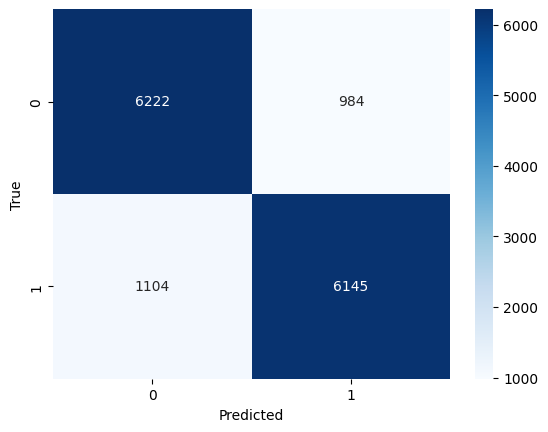

In [10]:
model1 = make_pipeline(vectorizer, MultinomialNB())
model1.fit(x_train, y_train)
predicted1 = model1.predict(x_test)
metricas(predicted1,y_test)

In [35]:
guardar_y_predecir(model1,"bayes_naive_model1_filter-stop-max40000")

Hago randomSearch para optimizar los hiperparámetros

In [11]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'multinomialnb__alpha': [0.1, 0.4, 0.5, 1.0],
    'multinomialnb__force_alpha': [True, False],
    'multinomialnb__class_prior': [None, [0.3, 0.7], [0.5, 0.5]],
    'multinomialnb__fit_prior': [True, False]
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    MultinomialNB()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1)

#Busco los hiperparamtros que optimizan F1 Score
model= randomcv.fit(x_train,y_train)


{'multinomialnb__force_alpha': True, 'multinomialnb__fit_prior': True, 'multinomialnb__class_prior': [0.5, 0.5], 'multinomialnb__alpha': 1.0}
              precision    recall  f1-score   support

    negativo      0.851     0.861     0.856      7206
    positivo      0.860     0.850     0.855      7249

    accuracy                          0.855     14455
   macro avg      0.856     0.855     0.855     14455
weighted avg      0.856     0.855     0.855     14455



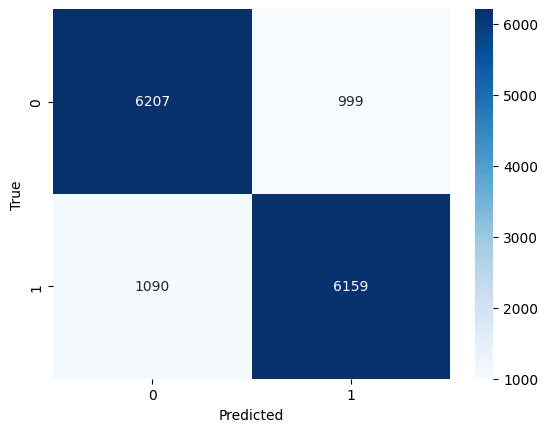

In [43]:
#Mejor estimador
best_bayes=model.best_estimator_

#Mejores parámetros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_bayes.predict(x_test)

metricas(y_pred,y_test)

In [44]:
guardar_y_predecir(best_bayes,"bayes_naive_best_model_filtrado_final")

# 2) Random Forest

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Build the model
modelRF = make_pipeline(vectorizer, RandomForestClassifier(n_jobs=-1))
# Indice de frecuencia invertido. Normaliza la cantidad de palabras.
# Le da mayor importancia a las palabras que menos aparecen

# Train the model using the training data
modelRF.fit(x_train, y_train)

# Predict the categories of the test data
predicted1 = modelRF.predict(x_test)

              precision    recall  f1-score   support

    negativo      0.830     0.855     0.842      7206
    positivo      0.851     0.826     0.838      7249

    accuracy                          0.840     14455
   macro avg      0.840     0.840     0.840     14455
weighted avg      0.841     0.840     0.840     14455



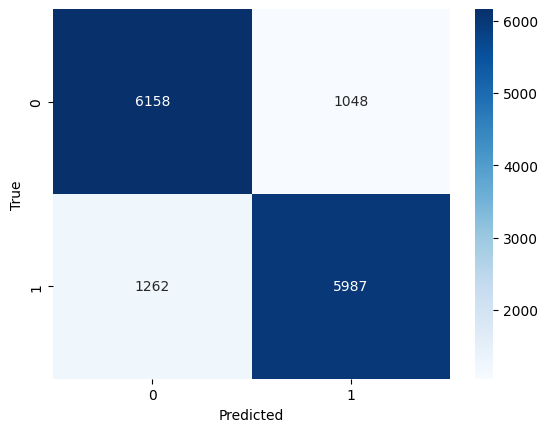

In [46]:
metricas(predicted1,y_test)

In [47]:
guardar_y_predecir(modelRF,"random_forest-filtrado")

Hago un randomsearch para optimizar los hiperparámetros

In [49]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = { "randomforestclassifier__criterion" : ["gini", "entropy"], 
                "randomforestclassifier__min_samples_leaf" : [1, 5, 10], 
                "randomforestclassifier__min_samples_split" : [2, 4, 10, 16], 
                "randomforestclassifier__n_estimators": [10, 20, 50, 100],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    RandomForestClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model = randomcv.fit(x_train,y_train)

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 16, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__criterion': 'entropy'}
              precision    recall  f1-score   support

    negativo      0.843     0.846     0.845      7206
    positivo      0.847     0.843     0.845      7249

    accuracy                          0.845     14455
   macro avg      0.845     0.845     0.845     14455
weighted avg      0.845     0.845     0.845     14455



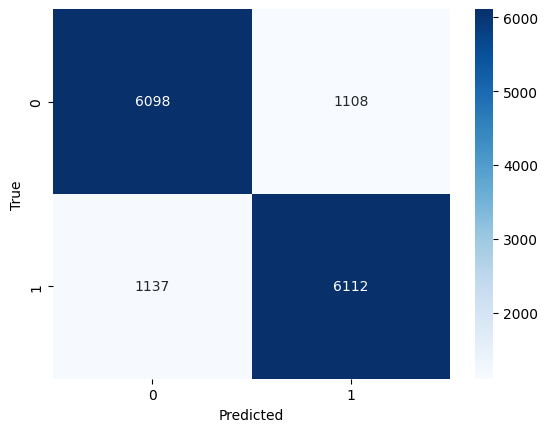

In [50]:
#Mejor estimador
best_RF=model.best_estimator_

#Mejores parametros
print(model.best_params_)

#Predicción con mejor estimador
y_pred=best_RF.predict(x_test)

metricas(y_pred,y_test)

In [51]:
guardar_y_predecir(best_RF,"random_forest_best-filtrado")

# 3) XGBoost

              precision    recall  f1-score   support

           0      0.856     0.816     0.835      7206
           1      0.825     0.863     0.844      7249

    accuracy                          0.840     14455
   macro avg      0.840     0.840     0.839     14455
weighted avg      0.840     0.840     0.839     14455



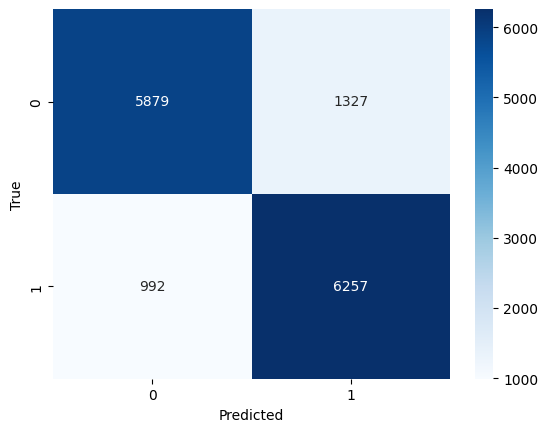

In [34]:
from xgboost import XGBClassifier
# Build the model

modelXGB = make_pipeline(vectorizer, XGBClassifier())

# Train the model using the training data
modelXGB.fit(x_train, y_train)

# Predict the categories of the test data
predictedXGB = modelXGB.predict(x_test)

metricas(predictedXGB,y_test)

In [67]:
guardar_y_predecir(modelXGB,"XGBoost-filtrado")

Hago un randomSearch para optimizar los hiperparámetros

In [35]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.15],
    'xgbclassifier__subsample': [0.6, 0.8, 1.0],
    'xgbclassifier__gamma': [0, 0.1, 0.5],
}
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    XGBClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n, n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model_XGB = randomcv.fit(x_train,y_train)

In [36]:
#Mejores hiperparametros
print(model_XGB.best_params_)
#Mejor métrica
print(model_XGB.best_score_)

{'xgbclassifier__subsample': 0.8, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.15, 'xgbclassifier__gamma': 0.5}
0.831114970779238


              precision    recall  f1-score   support

           0      0.857     0.798     0.826      7206
           1      0.812     0.867     0.839      7249

    accuracy                          0.833     14455
   macro avg      0.834     0.833     0.833     14455
weighted avg      0.834     0.833     0.833     14455



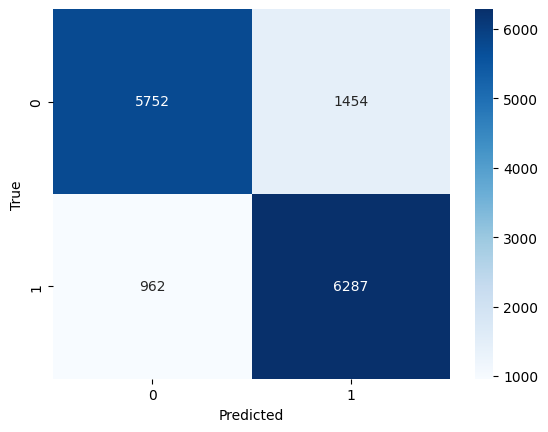

In [37]:
#Mejor estimador
best_XGB=model_XGB.best_estimator_

#Predicción con mejor estimador
y_pred=best_XGB.predict(x_test)

metricas(y_pred,y_test)

In [95]:
guardar_y_predecir(best_XGB,"xgboost_best-filtrado")

No dio buenos resultados, voy a probar otro set de hiperparámetros

In [ ]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer

#Cantidad de combinaciones que quiero probar
n=40

#Conjunto de parámetros que quiero usar
params_grid = { 'xgbclassifier__max_depth': [3,6,10],
           'xgbclassifier__learning_rate': [0.01, 0.05, 0.1],
           'xgbclassifier__n_estimators': [100, 500, 1000],
           'xgbclassifier__colsample_bytree': [0.3, 0.7]
           }
                
#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
pipeline = make_pipeline(
    vectorizer,
    XGBClassifier()
)
#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score)

#Random Search Cross Validation
randomcv = GridSearchCV(estimator=pipeline,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              verbose=1,
                              n_jobs=-1) 

#Busco los hiperparamtros que optimizan F1 Score
model_XGB = randomcv.fit(x_train,y_train)